In [1]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [2]:
import os

if not os.path.exists('CuPL'):
    !git clone https://github.com/sarahpratt/CuPL.git

In [3]:
import numpy as np
import torch
import clip
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)

In [6]:
import aml.datasets

dataset_test = aml.datasets.Caltech101(datasets_path, split='test')

In [7]:
cls_names_sorted = [dataset_test.lab2cname[label_id] for label_id in sorted(dataset_test.lab2cname.keys())]

In [8]:
# Create class name features
with torch.no_grad():
    cls_name_label_ids = np.arange(len(cls_names_sorted))
    cls_name_features_cuda = model.encode_text(clip.tokenize(cls_names_sorted).to(device))
    cls_name_features_cuda /= cls_name_features_cuda.norm(dim=-1, keepdim=True)
    cls_name_features = cls_name_features_cuda.cpu().numpy()

    # Fill diagonal for better visibility
    cls_name_masked_similarity = (cls_name_features_cuda @ cls_name_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

In [9]:
def calc_features(encoder, items_dict):
    with torch.no_grad():
        label_ids = []
        features_cuda = []
        cls_features_cuda = []
        for label_id in tqdm(range(len(cls_names_sorted))):
            items = items_dict.pop(label_id)
            label_ids.append([label_id] * len(items))
            class_embeddings = encoder(items)
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            features_cuda.append(class_embeddings)
            cls_features_cuda.append(class_embedding)
        label_ids = np.hstack(label_ids)
        features = torch.vstack(features_cuda).cpu().numpy()
        cls_features_cuda = torch.vstack(cls_features_cuda)

        # Fill diagonal for better visibility
        masked_similarity = (cls_features_cuda @ cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

    return label_ids, features, features_cuda, cls_features_cuda, masked_similarity

In [10]:
def encode_text(texts):
    with torch.no_grad():
        return model.encode_text(clip.tokenize(texts).to(device))

In [11]:
# Create template text features
template_label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(cls_names_sorted)}
template_label_ids, template_text_features, template_text_features_cuda, template_cls_features_cuda, template_masked_similarity = calc_features(encode_text, template_label_texts_list)

100%|██████████| 100/100 [00:01<00:00, 50.54it/s]


In [12]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/cal_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts_file = json.load(f)

In [13]:
# Mapping between CuPL and cls_name
special_class_mapping = {
    'centered face': 'face',
    'side of a car': 'car_side',
    'body of a cougar cat': 'cougar_body',
    'face of a cougar cat': 'cougar_face',
    'head of a crocodile': 'crocodile_head',
    'head of a flamingo': 'flamingo_head',
    'snoopy (cartoon beagle)': 'snoopy',
    'yin and yang symbol': 'yin_yang',
}

In [14]:
# Lookup CuLP prompts from cls_name
original_gpt3_prompts = {}

for gpt3_cls_name, texts in gpt3_prompts_file.items():
    cls_name = special_class_mapping.get(gpt3_cls_name, gpt3_cls_name).replace(' ', '_')
    if cls_name not in dataset_test.classnames:
        continue
    original_gpt3_prompts[cls_name] = texts

In [15]:
# Create original gpt3 text features
original_gpt3_label_texts_list = {label_id: original_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
original_gpt3_label_ids, original_gpt3_text_features, original_gpt3_text_features_cuda, original_gpt3_cls_features_cuda, original_gpt3_masked_similarity = calc_features(encode_text, original_gpt3_label_texts_list)

100%|██████████| 100/100 [00:00<00:00, 119.66it/s]


In [16]:
# Filter out outliers in gpt3 text features
with torch.no_grad():
    original_gpt3_text_similarity = [(features_cuda @ features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy() for features_cuda in original_gpt3_text_features_cuda]
    original_gpt3_text_similarity_mean = [np.nanmean(similarity, axis=0) for similarity in original_gpt3_text_similarity]
    threshold = np.cos(np.deg2rad(45))
    filtered_gpt3_prompts = {label_id: [text for similarity, text in zip(original_gpt3_text_similarity_mean[label_id], original_gpt3_prompts[cls_name]) if similarity >= threshold] for label_id, cls_name in enumerate(cls_names_sorted)}
    filtered_gpt3_prompts = {label_id: list(dict.fromkeys(texts)) for label_id, texts in filtered_gpt3_prompts.items()}
    outliers = {label_id: [text for similarity, text in zip(original_gpt3_text_similarity_mean[label_id], original_gpt3_prompts[cls_name]) if similarity < threshold] for label_id, cls_name in enumerate(cls_names_sorted)}
    for label_id, texts in outliers.items():
        if len(texts) != 0:
            print(f'Filtered {len(texts)} outliers for ({label_id}){cls_names_sorted[label_id]}')
            print(texts)
            print()

Filtered 4 outliers for (1)leopard
['This photo shows a leopard lounging in a tree.', 'The photo is of a leopard lying down on some rocks in a Savannah.', 'Jaguar on the prowl in Pantanal, Brazil.', 'This photo shows a leopard resting in a tree.']

Filtered 1 outliers for (3)accordion
['A man is playing an accordion in front of a brick building.']

Filtered 2 outliers for (4)airplane
['A large metal airplane is sitting on a runway with its wheels down.', 'This photo is of a small, silver airplane flying through a blue sky.']

Filtered 1 outliers for (5)anchor
['A neap tide frequency curve has how many phases?What is the capital of Yemen?.']

Filtered 2 outliers for (6)ant
['arctic glacierThe photo shows a large glacier in the Antarctic with a backdrop of mountains.', 'arctic expeditionThe photo is of a group of people in bulky coats and hats, standing on a sea of ice.']

Filtered 1 outliers for (7)barrel
[' raceA barrel race is a rodeo event in which a horse and rider attempt to comple

In [17]:
# Create filtered gpt3 text features
filtered_gpt3_label_texts_list = {label_id: filtered_gpt3_prompts[label_id] for label_id in range(len(cls_names_sorted))}
filtered_gpt3_label_ids, filtered_gpt3_text_features, filtered_gpt3_text_features_cuda, filtered_gpt3_cls_features_cuda, filtered_gpt3_masked_similarity = calc_features(encode_text, filtered_gpt3_label_texts_list)

100%|██████████| 100/100 [00:00<00:00, 143.58it/s]


In [18]:
def encode_images(imgs):
    with torch.no_grad():
        return model.encode_image(torch.stack([preprocess(img) for img in imgs]).to(device))

In [19]:
# Create image features
imgs_grouped = defaultdict(list)
for img, label_id in dataset_test:
    imgs_grouped[label_id].append(img)
img_label_ids, _, img_features_cuda, _, img_masked_similarity = calc_features(encode_images, imgs_grouped)

100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


In [20]:
import sklearn.metrics

def calc_clip_pred(label_ids, img_features_cuda, text_features_cuda):
    with torch.no_grad():
        if type(text_features_cuda) == list:  # list of tensors
            logits = torch.vstack([(img_features_cuda @ embeddings.T).mean(dim=-1) for embeddings in text_features_cuda]).T
        else:
            logits = img_features_cuda @ text_features_cuda.T
        pred = logits.argmax(dim=-1).cpu().numpy()

        return (pred == label_ids).mean(), sklearn.metrics.confusion_matrix(label_ids, pred, labels=np.arange(len(cls_names_sorted)), normalize='true')

In [21]:
# Combine template text with gpt3 text features
combined_original_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, original_gpt3_text_features_cuda)]
combined_filtered_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, filtered_gpt3_text_features_cuda)]
combined_original_gpt3_cls_features_cuda = []
combined_filtered_gpt3_cls_features_cuda = []
for class_embeddings in combined_original_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_original_gpt3_cls_features_cuda.append(class_embedding)
for class_embeddings in combined_filtered_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_filtered_gpt3_cls_features_cuda.append(class_embedding)
combined_original_gpt3_cls_features_cuda = torch.vstack(combined_original_gpt3_cls_features_cuda)
combined_filtered_gpt3_cls_features_cuda = torch.vstack(combined_filtered_gpt3_cls_features_cuda)

In [22]:
# Zero-shot classification of CLIP
img_features_stacked_cuda = torch.vstack(img_features_cuda)

cls_name_acc, cls_name_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, cls_name_features_cuda)
template_cls_acc, template_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_cls_features_cuda)
template_text_acc, template_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_text_features_cuda)
original_gpt3_cls_acc, original_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_cls_features_cuda)
original_gpt3_text_acc, original_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_text_features_cuda)
filtered_gpt3_cls_acc, filtered_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_cls_features_cuda)
filtered_gpt3_text_acc, filtered_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_text_features_cuda)
combined_original_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_cls_features_cuda)
combined_original_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_text_features_cuda)
combined_filtered_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_cls_features_cuda)
combined_filtered_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_text_features_cuda)

In [23]:
print(f'Accuracy of CLIP with class names: {cls_name_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (centroid): {template_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (individual avg): {template_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (centroid): {original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (individual avg): {original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (centroid): {filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (individual avg): {filtered_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (centroid): {combined_original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (individual avg): {combined_original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (centroid): {combined_filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (individual avg): {combined_filtered_gpt3_text_acc*100:.2f}%')

Accuracy of CLIP with class names: 87.14%
Accuracy of CLIP with text template (centroid): 93.10%
Accuracy of CLIP with text template (individual avg): 92.94%
Accuracy of CLIP with original GPT-3 text (centroid): 94.28%
Accuracy of CLIP with original GPT-3 text (individual avg): 94.16%
Accuracy of CLIP with filtered GPT-3 text (centroid): 94.44%
Accuracy of CLIP with filtered GPT-3 text (individual avg): 94.60%
Accuracy of CLIP with combined original GPT-3 text (centroid): 94.00%
Accuracy of CLIP with combined original GPT-3 text (individual avg): 93.87%
Accuracy of CLIP with combined filtered GPT-3 text (centroid): 93.96%
Accuracy of CLIP with combined filtered GPT-3 text (individual avg): 93.79%


In [24]:
# Zero-shot classification of CLIP using one text on all images
template_text_individual_features_cuda = list(torch.stack(template_text_features_cuda).permute(1, 0, 2))
template_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in template_text_individual_features_cuda])
original_gpt3_text_individual_features_cuda = list(torch.stack(original_gpt3_text_features_cuda).permute(1, 0, 2))
original_gpt3_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in original_gpt3_text_individual_features_cuda])

In [25]:
print(f'Accuracy of CLIP with text template (one text on all images): mean={template_text_individual_acc.mean()*100:.2f}%, std={template_text_individual_acc.std()}')
print(f'Accuracy of CLIP with original GPT-3 text (one text on all images): mean={original_gpt3_text_individual_acc.mean()*100:.2f}%, std={original_gpt3_text_individual_acc.std()}')

Accuracy of CLIP with text template (one text on all images): mean=90.45%, std=0.023761506019523548
Accuracy of CLIP with original GPT-3 text (one text on all images): mean=87.89%, std=0.040901365970246344


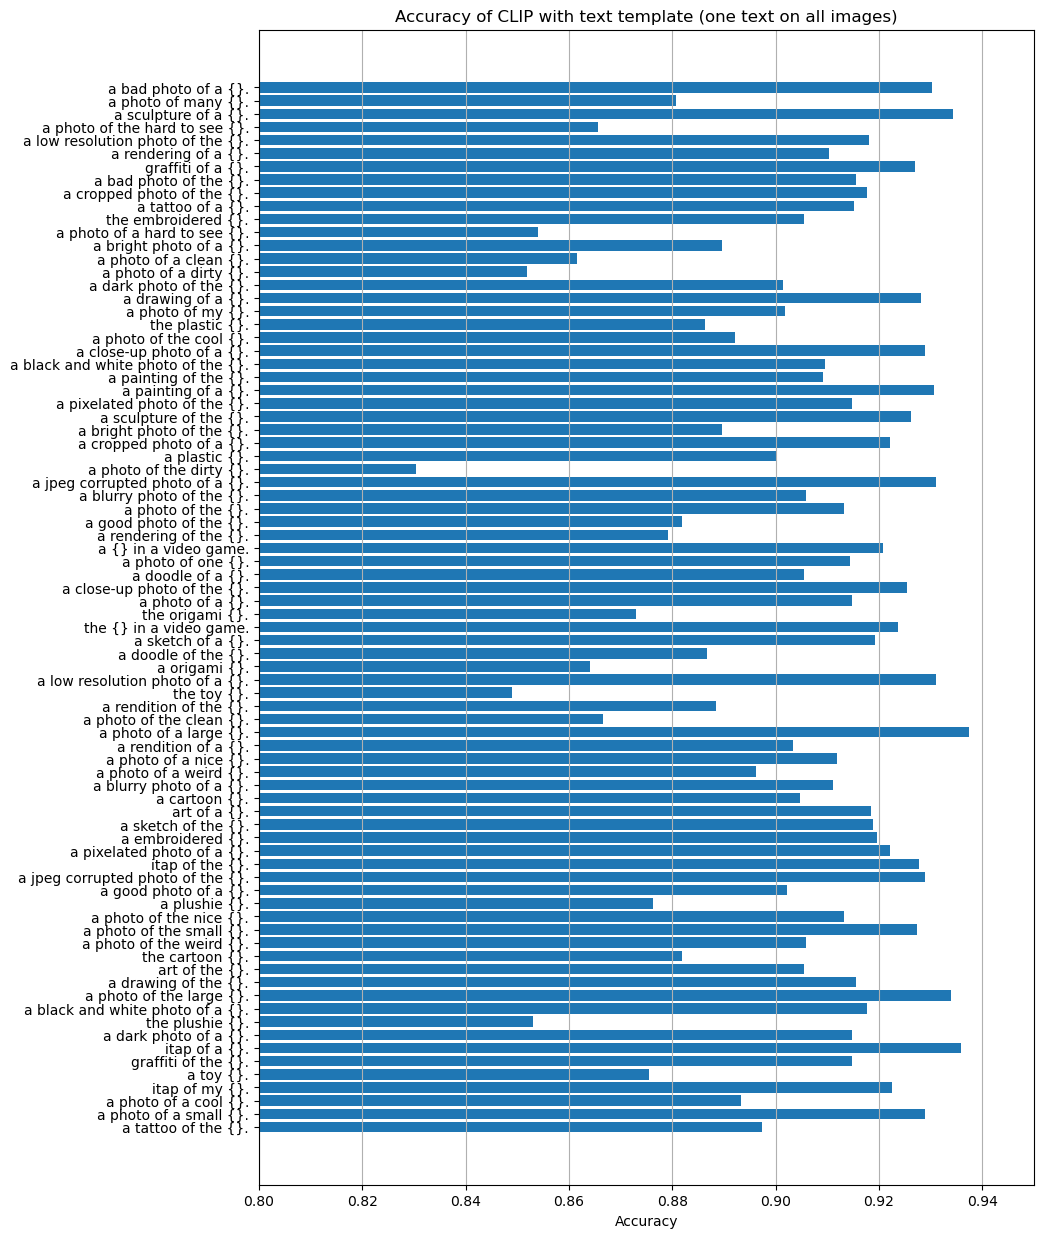

In [26]:
plt.figure(figsize=(10, 15))
plt.barh(np.arange(len(template_text_individual_acc)), template_text_individual_acc, align='center')
plt.yticks(np.arange(len(template_text_individual_acc)), imagenet_templates)
plt.xlabel('Accuracy')
plt.title('Accuracy of CLIP with text template (one text on all images)')
scale = 0.05
plt.xlim(int(template_text_individual_acc.min()/scale)*scale, (int(template_text_individual_acc.max()/scale)+1)*scale)
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.show()

In [27]:
def calc_features_similarity(features1_cuda, features2_cuda):
    with torch.no_grad():
        similarity_cuda = []
        for embeddings1 in features1_cuda:
            if type(features2_cuda) == list:  # list of tensors
                similarity_cuda.append(torch.Tensor([(embeddings1 @ embeddings2.T).mean() for embeddings2 in features2_cuda]))
            else:
                similarity_cuda.append((embeddings1 @ features2_cuda.T).mean(dim=0))

        return torch.vstack(similarity_cuda).cpu().numpy()

In [28]:
# Calculate similarity between image features and text features
img_cls_name_similarity = calc_features_similarity(img_features_cuda, cls_name_features_cuda)
img_template_cls_similarity = calc_features_similarity(img_features_cuda, template_cls_features_cuda)
img_template_text_similarity = calc_features_similarity(img_features_cuda, template_text_features_cuda)
img_original_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, original_gpt3_cls_features_cuda)
img_original_gpt3_text_similarity = calc_features_similarity(img_features_cuda, original_gpt3_text_features_cuda)
img_filtered_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_cls_features_cuda)
img_filtered_gpt3_text_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_text_features_cuda)

In [29]:
def print_top_pairs(similarity, text, top=10):
    # Get the indices of top values
    top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:top], similarity.shape)

    # Extract the class names and labels for top values
    for idx, (label1, label2) in enumerate(zip(*top_indices)):
        print(f'Rank {idx+1}: ({label1}){cls_names_sorted[label1]} - ({label2}){cls_names_sorted[label2]}, {text}: {similarity[label1, label2]}')

In [30]:
def plot_similarity(similarity, title, xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity)
    plt.xticks(np.arange(0, len(cls_names_sorted), 5))
    plt.yticks(np.arange(0, len(cls_names_sorted), 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [31]:
def plot_cm(cm, title):
    plt.figure(figsize=(12, 10))
    plt.imshow(cm)
    plt.xticks(np.arange(0, len(cls_names_sorted), 5))
    plt.yticks(np.arange(0, len(cls_names_sorted), 5))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

In [32]:
def visualize_auto_similarity(masked_similarity, title):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.nanstd(masked_similarity)}')
    print_top_pairs(np.triu(masked_similarity, k=1), 'similarity')
    plot_similarity(masked_similarity, title_similarity)

In [33]:
def visualize_cross_similarity(similarity, cm, title, xlabel='Text', ylabel='Image'):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.mean(similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.std(similarity)}')
    diagonal_similarity = similarity.diagonal()
    print(f'{title_similarity.capitalize()} diagonal mean: {np.mean(diagonal_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal std: {np.std(diagonal_similarity)}')
    masked_similarity = similarity.copy()
    np.fill_diagonal(masked_similarity, np.nan)
    print(f'{title_similarity.capitalize()} non-diagonal mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} non-diagonal std: {np.nanstd(masked_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal mean to non-diagonal mean ratio: {np.mean(diagonal_similarity)/np.nanmean(masked_similarity)}')
    print_top_pairs(masked_similarity, 'similarity', top=20)
    plot_similarity(similarity, title_similarity, xlabel=xlabel, ylabel=ylabel)
    masked_cm = cm.copy()
    np.fill_diagonal(masked_cm, np.nan)
    print_top_pairs(masked_cm, 'error rate', top=20)
    plot_cm(cm, title + ' Confusion Matrix')

Class name similarity mean: 0.69970703125
Class name similarity std: 0.07928466796875
Rank 1: (27)crocodile - (28)crocodile_head, similarity: 0.94677734375
Rank 2: (23)cougar_body - (24)cougar_face, similarity: 0.923828125
Rank 3: (40)flamingo - (41)flamingo_head, similarity: 0.90966796875
Rank 4: (25)crab - (26)crayfish, similarity: 0.8984375
Rank 5: (0)face - (12)brain, similarity: 0.89208984375
Rank 6: (21)chair - (95)wheelchair, similarity: 0.89013671875
Rank 7: (0)face - (24)cougar_face, similarity: 0.89013671875
Rank 8: (25)crab - (58)lobster, similarity: 0.8837890625
Rank 9: (15)butterfly - (33)dragonfly, similarity: 0.8818359375
Rank 10: (26)crayfish - (58)lobster, similarity: 0.8798828125


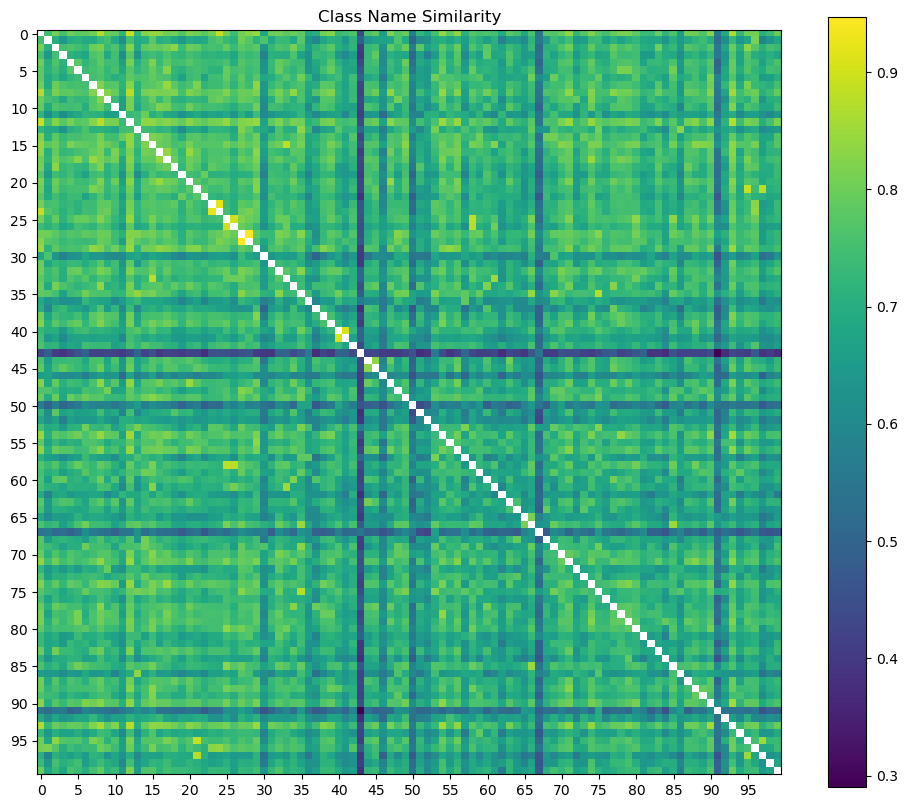

Text template similarity mean: 0.69482421875
Text template similarity std: 0.08038330078125
Rank 1: (27)crocodile - (28)crocodile_head, similarity: 0.955078125
Rank 2: (40)flamingo - (41)flamingo_head, similarity: 0.9287109375
Rank 3: (23)cougar_body - (24)cougar_face, similarity: 0.91748046875
Rank 4: (26)crayfish - (58)lobster, similarity: 0.89990234375
Rank 5: (25)crab - (26)crayfish, similarity: 0.89453125
Rank 6: (25)crab - (58)lobster, similarity: 0.89453125
Rank 7: (16)camera - (20)cellphone, similarity: 0.890625
Rank 8: (4)airplane - (49)helicopter, similarity: 0.890625
Rank 9: (21)chair - (95)wheelchair, similarity: 0.888671875
Rank 10: (0)face - (12)brain, similarity: 0.88818359375


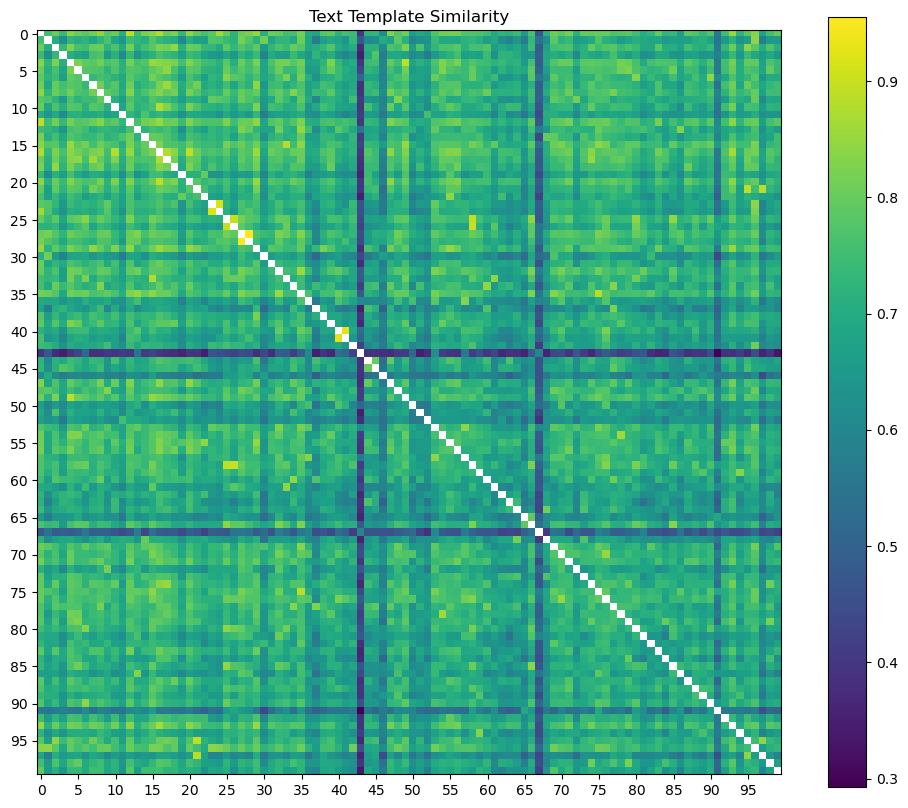

Original gpt-3 text similarity mean: 0.6708984375
Original gpt-3 text similarity std: 0.088134765625
Rank 1: (27)crocodile - (28)crocodile_head, similarity: 0.9716796875
Rank 2: (23)cougar_body - (24)cougar_face, similarity: 0.96142578125
Rank 3: (40)flamingo - (41)flamingo_head, similarity: 0.9169921875
Rank 4: (54)ketch - (78)schooner, similarity: 0.9150390625
Rank 5: (26)crayfish - (58)lobster, similarity: 0.9111328125
Rank 6: (23)cougar_body - (96)wild_cat, similarity: 0.908203125
Rank 7: (25)crab - (58)lobster, similarity: 0.90576171875
Rank 8: (24)cougar_face - (96)wild_cat, similarity: 0.89990234375
Rank 9: (59)lotus - (94)water_lilly, similarity: 0.8984375
Rank 10: (35)elephant - (75)rhino, similarity: 0.89794921875


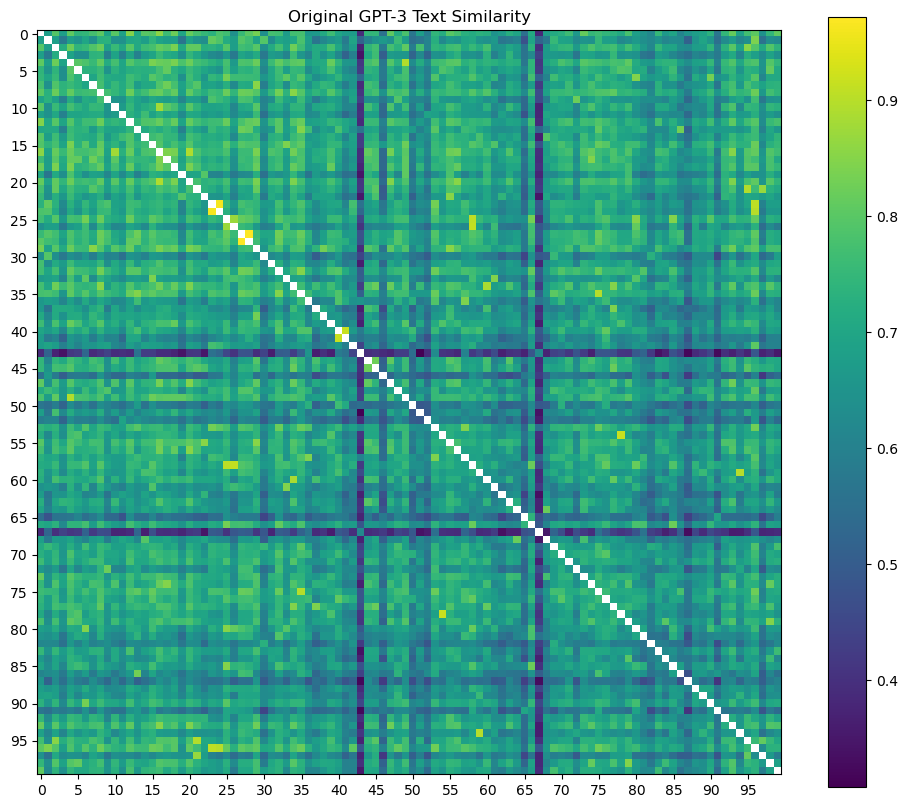

Filtered gpt-3 text similarity mean: 0.66943359375
Filtered gpt-3 text similarity std: 0.089599609375
Rank 1: (27)crocodile - (28)crocodile_head, similarity: 0.9716796875
Rank 2: (23)cougar_body - (24)cougar_face, similarity: 0.9619140625
Rank 3: (40)flamingo - (41)flamingo_head, similarity: 0.91748046875
Rank 4: (54)ketch - (78)schooner, similarity: 0.91357421875
Rank 5: (26)crayfish - (58)lobster, similarity: 0.91357421875
Rank 6: (25)crab - (58)lobster, similarity: 0.90771484375
Rank 7: (23)cougar_body - (96)wild_cat, similarity: 0.90771484375
Rank 8: (35)elephant - (75)rhino, similarity: 0.90185546875
Rank 9: (24)cougar_face - (96)wild_cat, similarity: 0.89794921875
Rank 10: (59)lotus - (94)water_lilly, similarity: 0.89794921875


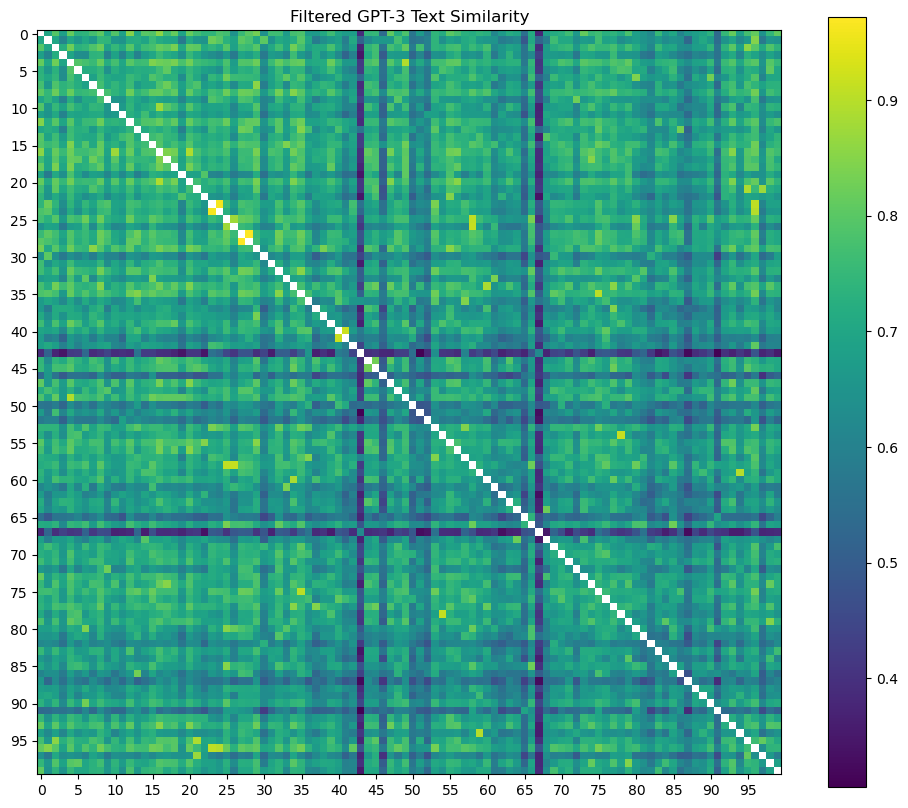

In [34]:
# Auto-similarity of text features
visualize_auto_similarity(cls_name_masked_similarity, 'Class Name')
visualize_auto_similarity(template_masked_similarity, 'Text Template')
visualize_auto_similarity(original_gpt3_masked_similarity, 'Original GPT-3 Text')
visualize_auto_similarity(filtered_gpt3_masked_similarity, 'Filtered GPT-3 Text')

Image similarity mean: 0.7080078125
Image similarity std: 0.06591796875
Rank 1: (59)lotus - (94)water_lilly, similarity: 0.9833984375
Rank 2: (54)ketch - (78)schooner, similarity: 0.97509765625
Rank 3: (27)crocodile - (28)crocodile_head, similarity: 0.96826171875
Rank 4: (21)chair - (97)windsor_chair, similarity: 0.96630859375
Rank 5: (26)crayfish - (58)lobster, similarity: 0.96240234375
Rank 6: (23)cougar_body - (24)cougar_face, similarity: 0.96044921875
Rank 7: (40)flamingo - (41)flamingo_head, similarity: 0.95751953125
Rank 8: (26)crayfish - (80)scorpion, similarity: 0.95556640625
Rank 9: (25)crab - (26)crayfish, similarity: 0.94873046875
Rank 10: (33)dragonfly - (61)mayfly, similarity: 0.94873046875


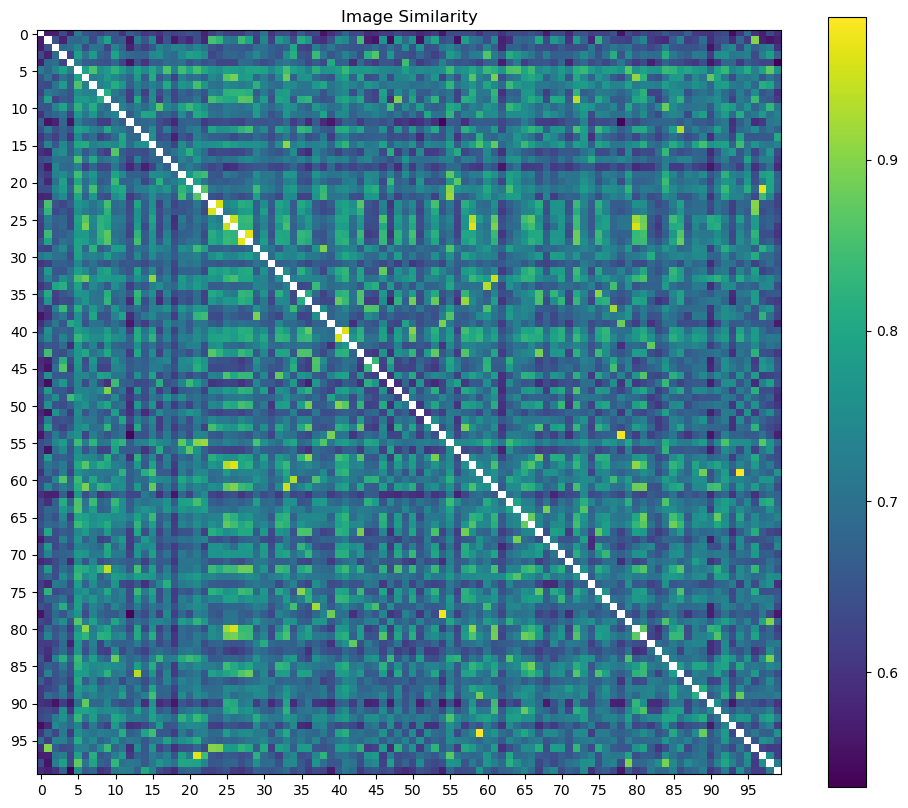

Image to class name similarity mean: 0.1925048828125
Image to class name similarity std: 0.0236358642578125
Image to class name similarity diagonal mean: 0.298583984375
Image to class name similarity diagonal std: 0.0182037353515625
Image to class name similarity non-diagonal mean: 0.19140625
Image to class name similarity non-diagonal std: 0.0211029052734375
Image to class name similarity diagonal mean to non-diagonal mean ratio: 1.5595703125
Rank 1: (40)flamingo - (41)flamingo_head, similarity: 0.2998046875
Rank 2: (97)windsor_chair - (21)chair, similarity: 0.299560546875
Rank 3: (21)chair - (97)windsor_chair, similarity: 0.297119140625
Rank 4: (41)flamingo_head - (40)flamingo, similarity: 0.29443359375
Rank 5: (59)lotus - (94)water_lilly, similarity: 0.2939453125
Rank 6: (28)crocodile_head - (27)crocodile, similarity: 0.293701171875
Rank 7: (54)ketch - (78)schooner, similarity: 0.293212890625
Rank 8: (58)lobster - (26)crayfish, similarity: 0.2919921875
Rank 9: (23)cougar_body - (24)

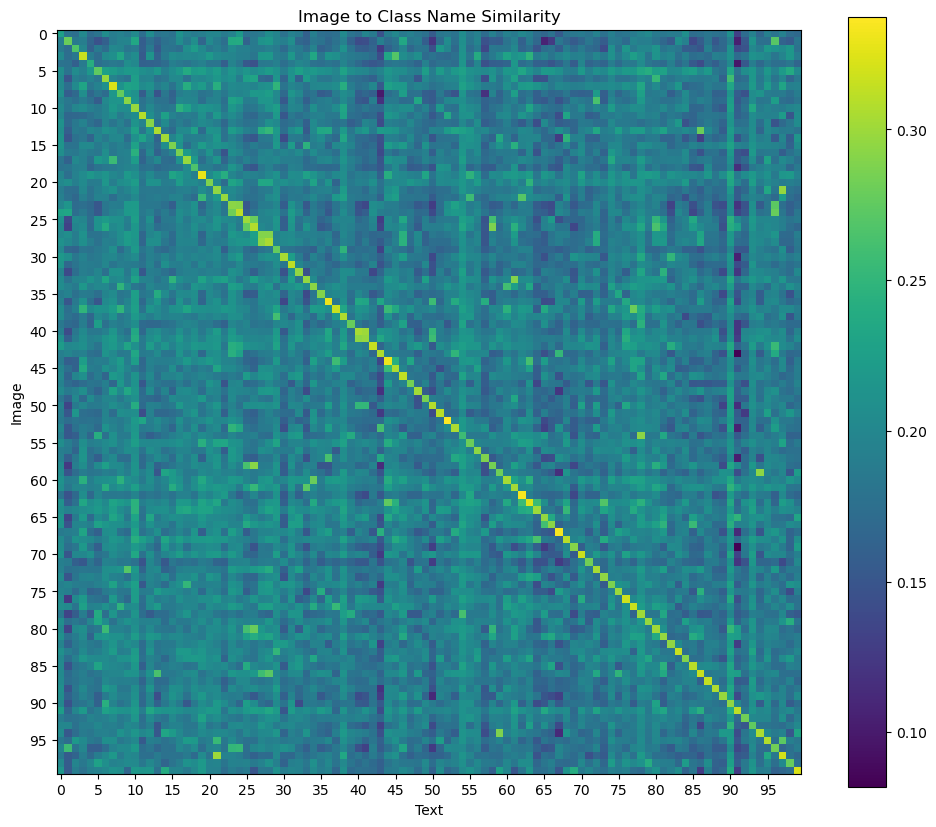

Rank 1: (54)ketch - (78)schooner, error rate: 1.0
Rank 2: (59)lotus - (94)water_lilly, error rate: 0.75
Rank 3: (21)chair - (97)windsor_chair, error rate: 0.5789473684210527
Rank 4: (58)lobster - (26)crayfish, error rate: 0.5384615384615384
Rank 5: (27)crocodile - (28)crocodile_head, error rate: 0.4666666666666667
Rank 6: (23)cougar_body - (24)cougar_face, error rate: 0.42857142857142855
Rank 7: (41)flamingo_head - (40)flamingo, error rate: 0.42857142857142855
Rank 8: (40)flamingo - (41)flamingo_head, error rate: 0.35
Rank 9: (33)dragonfly - (61)mayfly, error rate: 0.3
Rank 10: (0)face - (6)ant, error rate: 0.23846153846153847
Rank 11: (0)face - (24)cougar_face, error rate: 0.18461538461538463
Rank 12: (98)wrench - (79)scissors, error rate: 0.18181818181818182
Rank 13: (60)mandolin - (34)electric_guitar, error rate: 0.16666666666666666
Rank 14: (22)chandelier - (62)menorah, error rate: 0.15625
Rank 15: (5)anchor - (98)wrench, error rate: 0.15384615384615385
Rank 16: (1)leopard - (96)wi

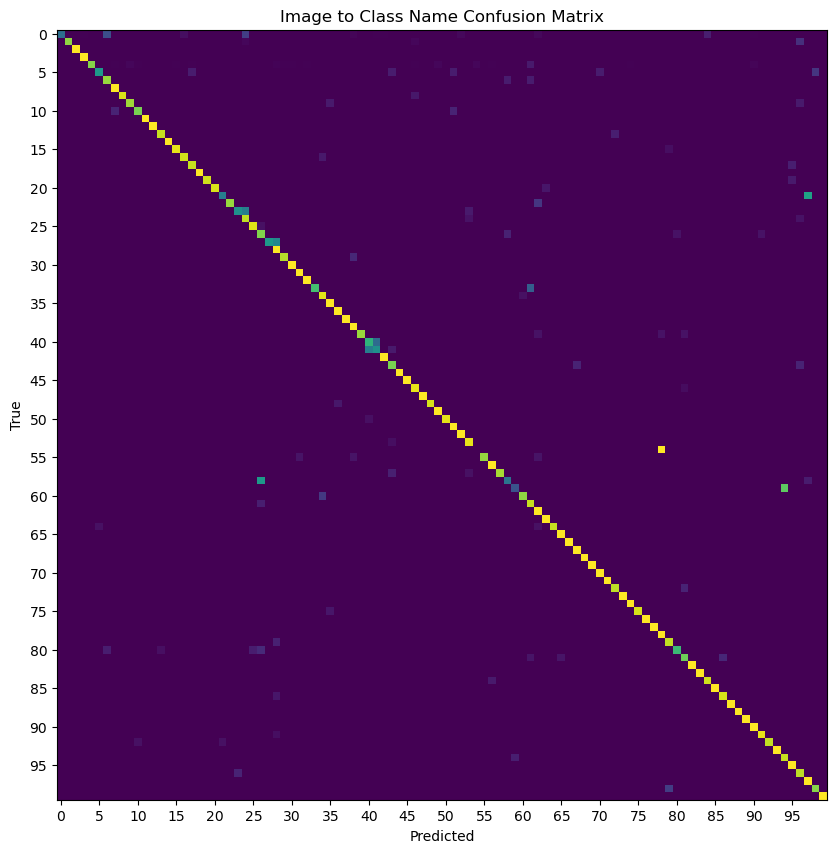

Image to text template (centroid) similarity mean: 0.1964111328125
Image to text template (centroid) similarity std: 0.0265045166015625
Image to text template (centroid) similarity diagonal mean: 0.322998046875
Image to text template (centroid) similarity diagonal std: 0.018768310546875
Image to text template (centroid) similarity non-diagonal mean: 0.1951904296875
Image to text template (centroid) similarity non-diagonal std: 0.0233001708984375
Image to text template (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.654296875
Rank 1: (78)schooner - (54)ketch, similarity: 0.323486328125
Rank 2: (41)flamingo_head - (40)flamingo, similarity: 0.3232421875
Rank 3: (24)cougar_face - (23)cougar_body, similarity: 0.3212890625
Rank 4: (28)crocodile_head - (27)crocodile, similarity: 0.3203125
Rank 5: (40)flamingo - (41)flamingo_head, similarity: 0.31884765625
Rank 6: (23)cougar_body - (24)cougar_face, similarity: 0.31787109375
Rank 7: (97)windsor_chair - (21)chair, similarity: 0

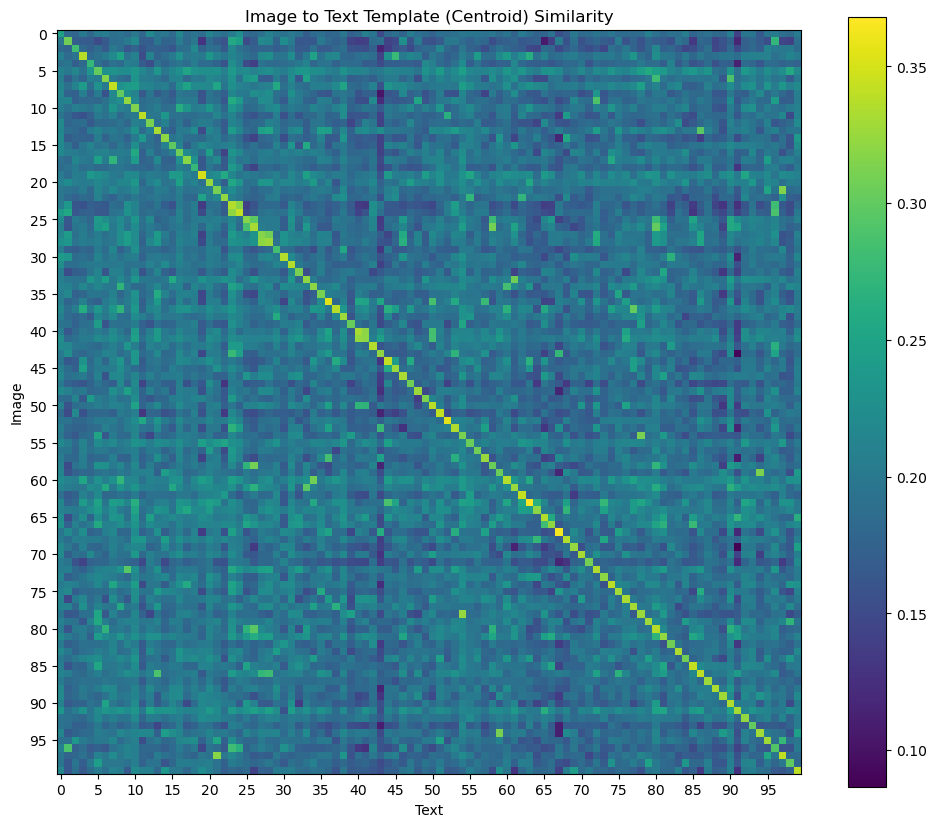

Rank 1: (21)chair - (97)windsor_chair, error rate: 0.7368421052631579
Rank 2: (59)lotus - (94)water_lilly, error rate: 0.65
Rank 3: (41)flamingo_head - (40)flamingo, error rate: 0.5714285714285714
Rank 4: (54)ketch - (78)schooner, error rate: 0.5
Rank 5: (96)wild_cat - (1)leopard, error rate: 0.5
Rank 6: (58)lobster - (26)crayfish, error rate: 0.46153846153846156
Rank 7: (78)schooner - (54)ketch, error rate: 0.3333333333333333
Rank 8: (33)dragonfly - (61)mayfly, error rate: 0.3
Rank 9: (96)wild_cat - (23)cougar_body, error rate: 0.2
Rank 10: (98)wrench - (79)scissors, error rate: 0.18181818181818182
Rank 11: (5)anchor - (98)wrench, error rate: 0.15384615384615385
Rank 12: (84)stapler - (51)inline_skate, error rate: 0.14285714285714285
Rank 13: (9)beaver - (23)cougar_body, error rate: 0.14285714285714285
Rank 14: (28)crocodile_head - (27)crocodile, error rate: 0.13333333333333333
Rank 15: (29)cup - (38)ewer, error rate: 0.1111111111111111
Rank 16: (43)gerenuk - (67)okapi, error rate: 0.

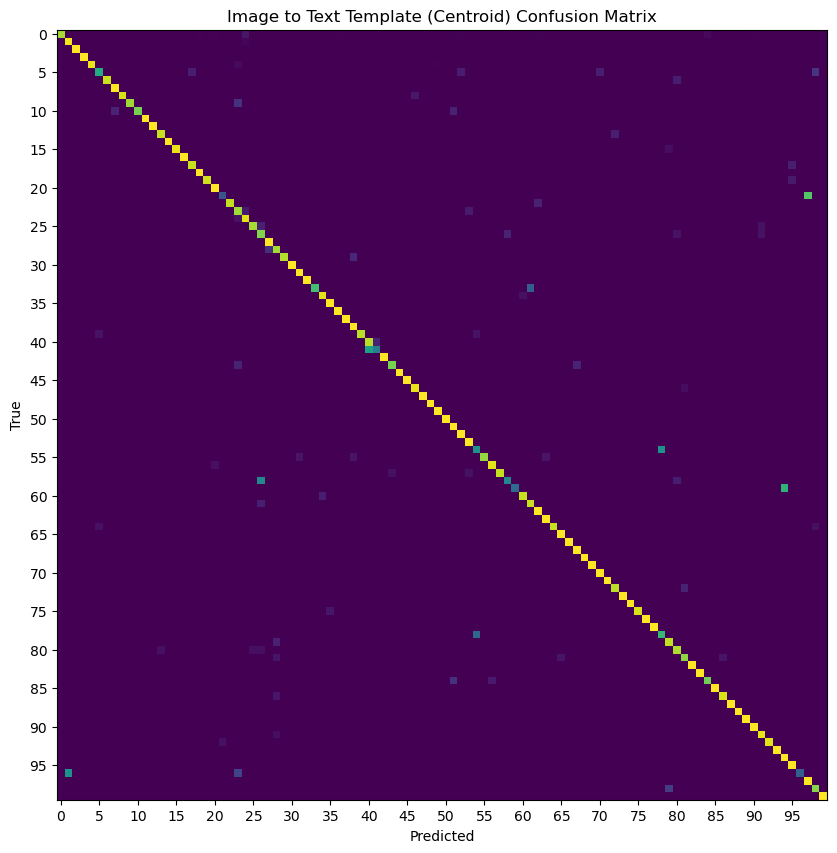

Image to text template (individual avg) similarity mean: 0.17965322732925415
Image to text template (individual avg) similarity std: 0.024276724085211754
Image to text template (individual avg) similarity diagonal mean: 0.29536986351013184
Image to text template (individual avg) similarity diagonal std: 0.01737390272319317
Image to text template (individual avg) similarity non-diagonal mean: 0.17848435044288635
Image to text template (individual avg) similarity non-diagonal std: 0.021345753222703934
Image to text template (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.6548782587051392
Rank 1: (24)cougar_face - (23)cougar_body, similarity: 0.29443359375
Rank 2: (78)schooner - (54)ketch, similarity: 0.29443359375
Rank 3: (41)flamingo_head - (40)flamingo, similarity: 0.29443359375
Rank 4: (40)flamingo - (41)flamingo_head, similarity: 0.29345703125
Rank 5: (28)crocodile_head - (27)crocodile, similarity: 0.292724609375
Rank 6: (97)windsor_chair - (21)chair, similari

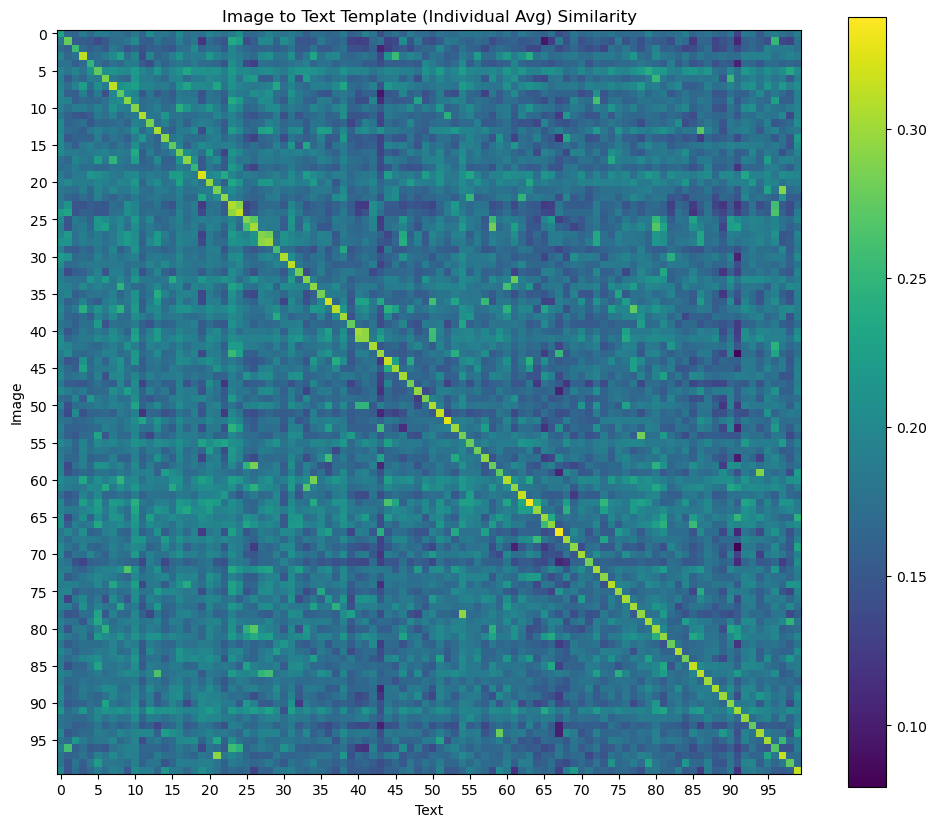

Rank 1: (59)lotus - (94)water_lilly, error rate: 0.8
Rank 2: (21)chair - (97)windsor_chair, error rate: 0.7368421052631579
Rank 3: (58)lobster - (26)crayfish, error rate: 0.5384615384615384
Rank 4: (96)wild_cat - (1)leopard, error rate: 0.5
Rank 5: (41)flamingo_head - (40)flamingo, error rate: 0.5
Rank 6: (54)ketch - (78)schooner, error rate: 0.47058823529411764
Rank 7: (78)schooner - (54)ketch, error rate: 0.3888888888888889
Rank 8: (33)dragonfly - (61)mayfly, error rate: 0.3
Rank 9: (96)wild_cat - (23)cougar_body, error rate: 0.2
Rank 10: (98)wrench - (79)scissors, error rate: 0.18181818181818182
Rank 11: (5)anchor - (98)wrench, error rate: 0.15384615384615385
Rank 12: (9)beaver - (23)cougar_body, error rate: 0.14285714285714285
Rank 13: (84)stapler - (51)inline_skate, error rate: 0.14285714285714285
Rank 14: (29)cup - (38)ewer, error rate: 0.1111111111111111
Rank 15: (43)gerenuk - (67)okapi, error rate: 0.1
Rank 16: (72)platypus - (81)sea_horse, error rate: 0.1
Rank 17: (10)binocula

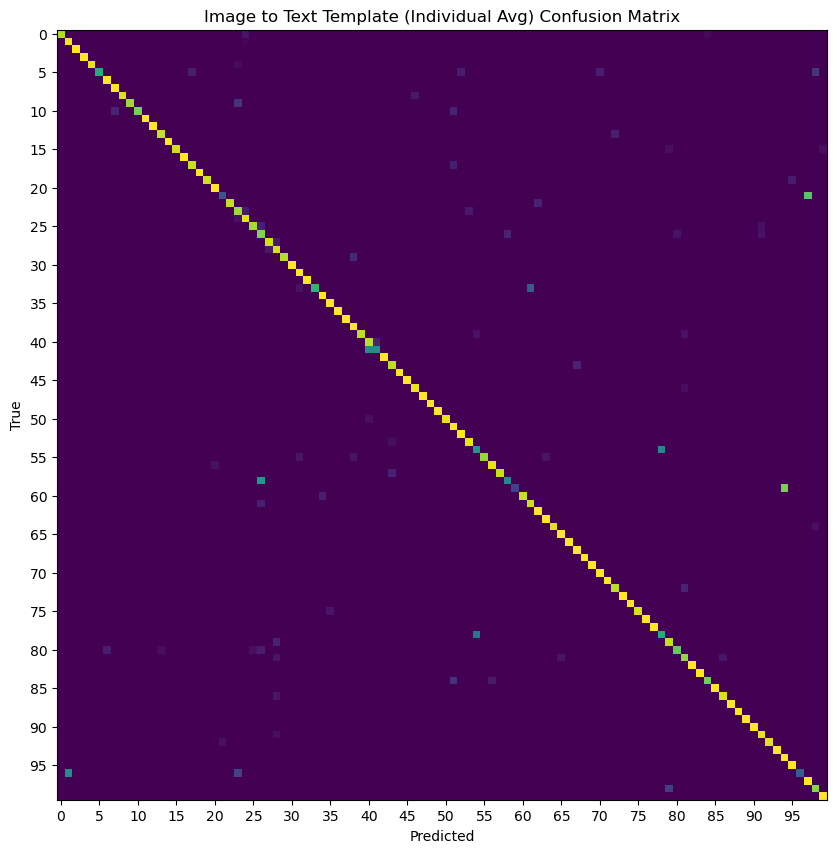

Image to original gpt-3 text (centroid) similarity mean: 0.195556640625
Image to original gpt-3 text (centroid) similarity std: 0.0283050537109375
Image to original gpt-3 text (centroid) similarity diagonal mean: 0.333251953125
Image to original gpt-3 text (centroid) similarity diagonal std: 0.0185546875
Image to original gpt-3 text (centroid) similarity non-diagonal mean: 0.1942138671875
Image to original gpt-3 text (centroid) similarity non-diagonal std: 0.0247650146484375
Image to original gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.7158203125
Rank 1: (94)water_lilly - (59)lotus, similarity: 0.337646484375
Rank 2: (78)schooner - (54)ketch, similarity: 0.3349609375
Rank 3: (28)crocodile_head - (27)crocodile, similarity: 0.333251953125
Rank 4: (41)flamingo_head - (40)flamingo, similarity: 0.332763671875
Rank 5: (40)flamingo - (41)flamingo_head, similarity: 0.330322265625
Rank 6: (24)cougar_face - (23)cougar_body, similarity: 0.32666015625
Rank 7: (59)l

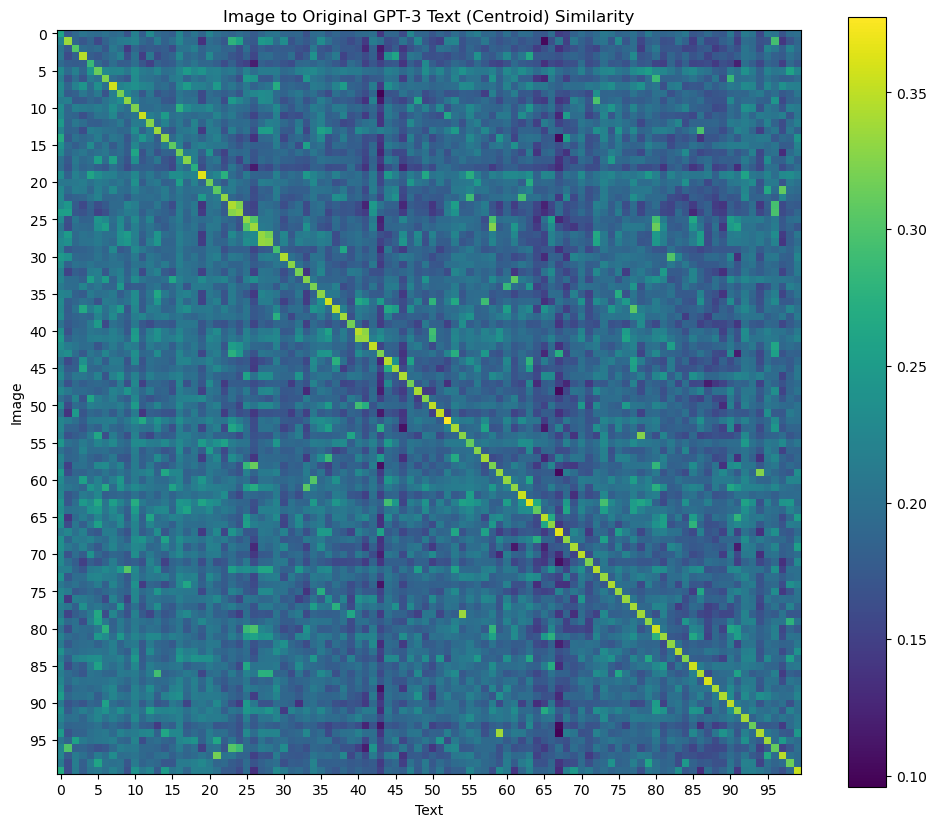

Rank 1: (28)crocodile_head - (27)crocodile, error rate: 0.8
Rank 2: (21)chair - (97)windsor_chair, error rate: 0.631578947368421
Rank 3: (94)water_lilly - (59)lotus, error rate: 0.4166666666666667
Rank 4: (78)schooner - (54)ketch, error rate: 0.3888888888888889
Rank 5: (59)lotus - (94)water_lilly, error rate: 0.35
Rank 6: (58)lobster - (26)crayfish, error rate: 0.3076923076923077
Rank 7: (96)wild_cat - (23)cougar_body, error rate: 0.3
Rank 8: (96)wild_cat - (1)leopard, error rate: 0.3
Rank 9: (54)ketch - (78)schooner, error rate: 0.29411764705882354
Rank 10: (41)flamingo_head - (40)flamingo, error rate: 0.2857142857142857
Rank 11: (33)dragonfly - (61)mayfly, error rate: 0.25
Rank 12: (26)crayfish - (58)lobster, error rate: 0.23809523809523808
Rank 13: (29)cup - (38)ewer, error rate: 0.1111111111111111
Rank 14: (43)gerenuk - (67)okapi, error rate: 0.1
Rank 15: (10)binocular - (51)inline_skate, error rate: 0.1
Rank 16: (10)binocular - (7)barrel, error rate: 0.1
Rank 17: (43)gerenuk - (23

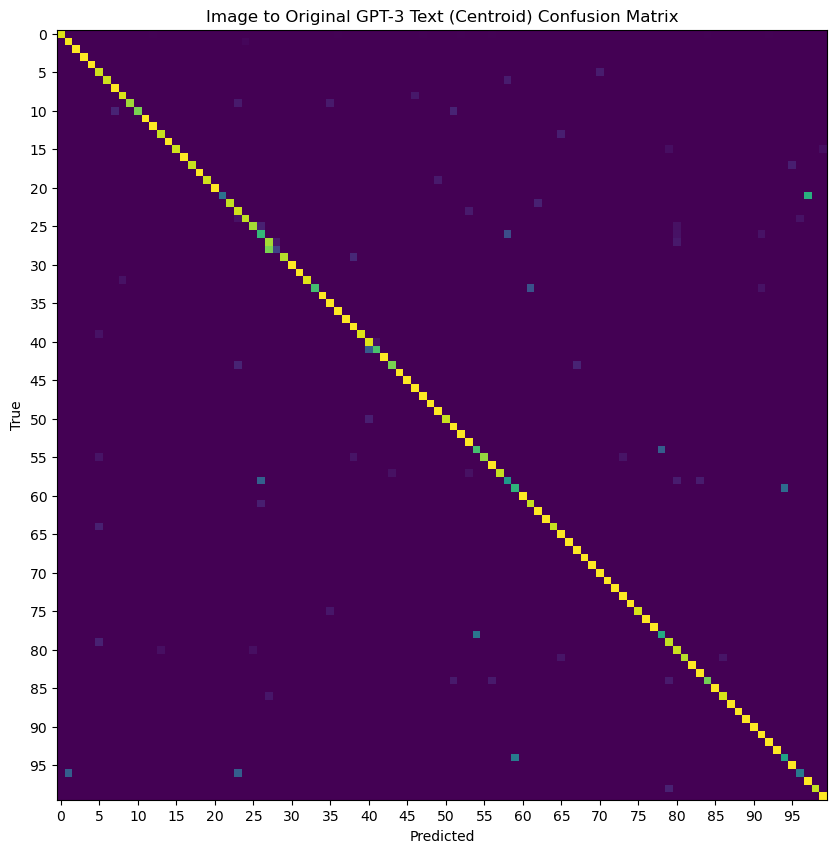

Image to original gpt-3 text (individual avg) similarity mean: 0.18378494679927826
Image to original gpt-3 text (individual avg) similarity std: 0.026468710973858833
Image to original gpt-3 text (individual avg) similarity diagonal mean: 0.3132971227169037
Image to original gpt-3 text (individual avg) similarity diagonal std: 0.019151650369167328
Image to original gpt-3 text (individual avg) similarity non-diagonal mean: 0.18247675895690918
Image to original gpt-3 text (individual avg) similarity non-diagonal std: 0.023082999512553215
Image to original gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.716915249824524
Rank 1: (78)schooner - (54)ketch, similarity: 0.32080078125
Rank 2: (28)crocodile_head - (27)crocodile, similarity: 0.3154296875
Rank 3: (40)flamingo - (41)flamingo_head, similarity: 0.31396484375
Rank 4: (41)flamingo_head - (40)flamingo, similarity: 0.313232421875
Rank 5: (54)ketch - (78)schooner, similarity: 0.31298828125
Rank 6: (94)wate

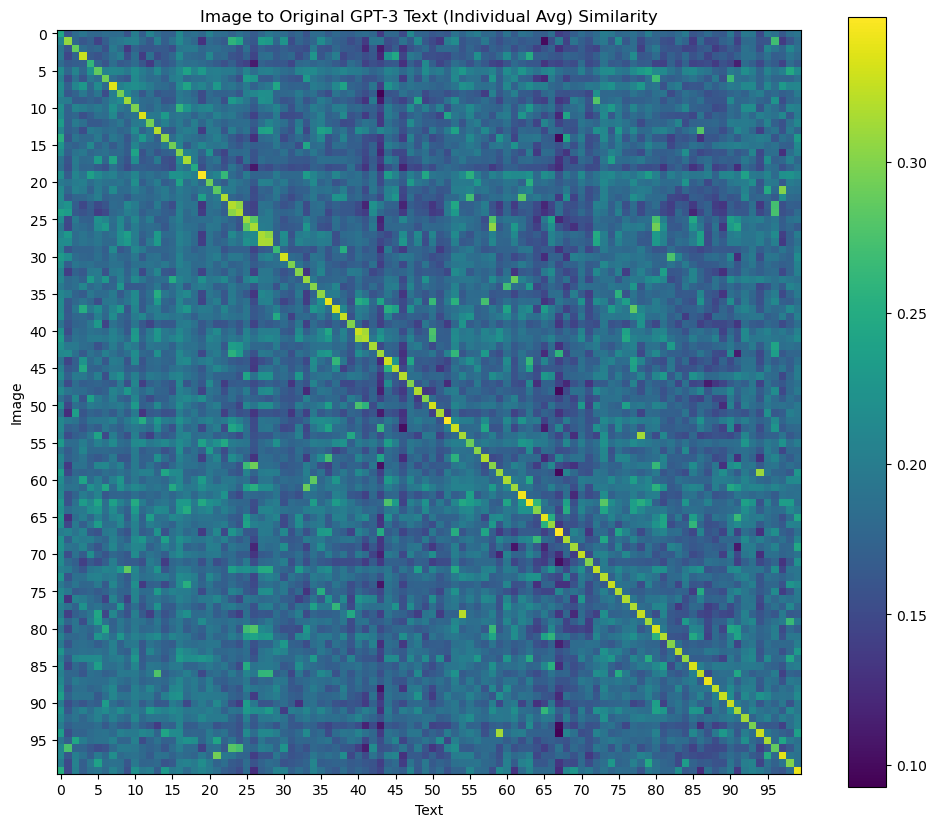

Rank 1: (21)chair - (97)windsor_chair, error rate: 0.8947368421052632
Rank 2: (28)crocodile_head - (27)crocodile, error rate: 0.4666666666666667
Rank 3: (59)lotus - (94)water_lilly, error rate: 0.45
Rank 4: (54)ketch - (78)schooner, error rate: 0.4411764705882353
Rank 5: (29)cup - (38)ewer, error rate: 0.3333333333333333
Rank 6: (58)lobster - (26)crayfish, error rate: 0.3076923076923077
Rank 7: (96)wild_cat - (1)leopard, error rate: 0.3
Rank 8: (96)wild_cat - (23)cougar_body, error rate: 0.3
Rank 9: (41)flamingo_head - (40)flamingo, error rate: 0.2857142857142857
Rank 10: (78)schooner - (54)ketch, error rate: 0.2777777777777778
Rank 11: (26)crayfish - (58)lobster, error rate: 0.23809523809523808
Rank 12: (33)dragonfly - (61)mayfly, error rate: 0.2
Rank 13: (43)gerenuk - (67)okapi, error rate: 0.1
Rank 14: (10)binocular - (51)inline_skate, error rate: 0.1
Rank 15: (42)garfield - (82)snoopy, error rate: 0.1
Rank 16: (43)gerenuk - (23)cougar_body, error rate: 0.1
Rank 17: (10)binocular - 

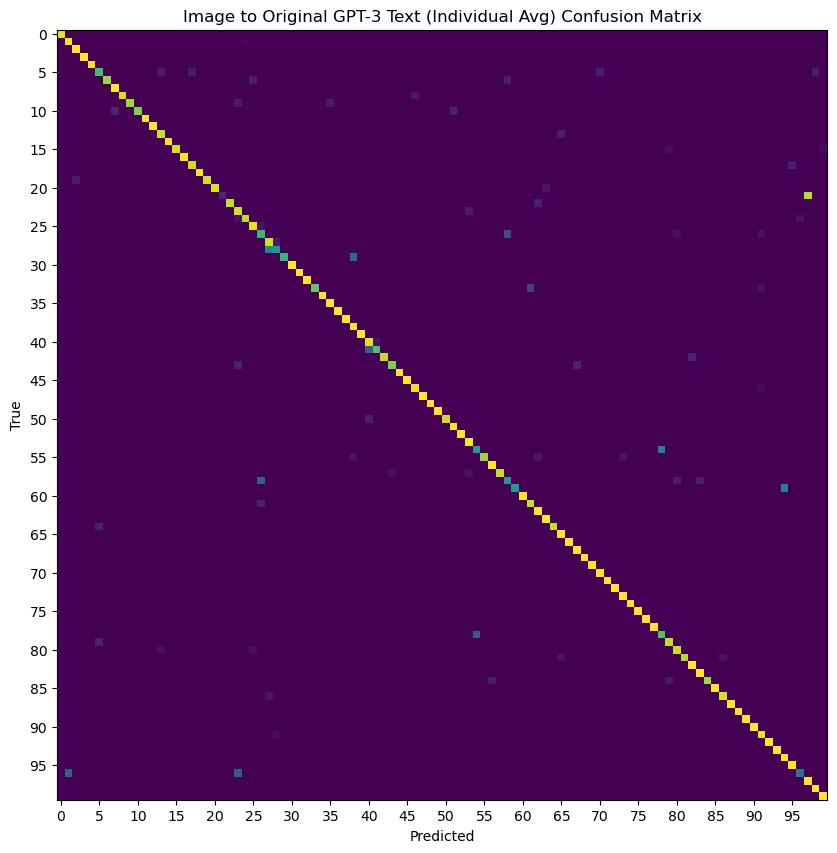

Image to filtered gpt-3 text (centroid) similarity mean: 0.195068359375
Image to filtered gpt-3 text (centroid) similarity std: 0.0283355712890625
Image to filtered gpt-3 text (centroid) similarity diagonal mean: 0.3330078125
Image to filtered gpt-3 text (centroid) similarity diagonal std: 0.018310546875
Image to filtered gpt-3 text (centroid) similarity non-diagonal mean: 0.193603515625
Image to filtered gpt-3 text (centroid) similarity non-diagonal std: 0.0247802734375
Image to filtered gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.7197265625
Rank 1: (94)water_lilly - (59)lotus, similarity: 0.3349609375
Rank 2: (78)schooner - (54)ketch, similarity: 0.33349609375
Rank 3: (28)crocodile_head - (27)crocodile, similarity: 0.333251953125
Rank 4: (41)flamingo_head - (40)flamingo, similarity: 0.330810546875
Rank 5: (40)flamingo - (41)flamingo_head, similarity: 0.330322265625
Rank 6: (59)lotus - (94)water_lilly, similarity: 0.326171875
Rank 7: (54)ketch - (78)sc

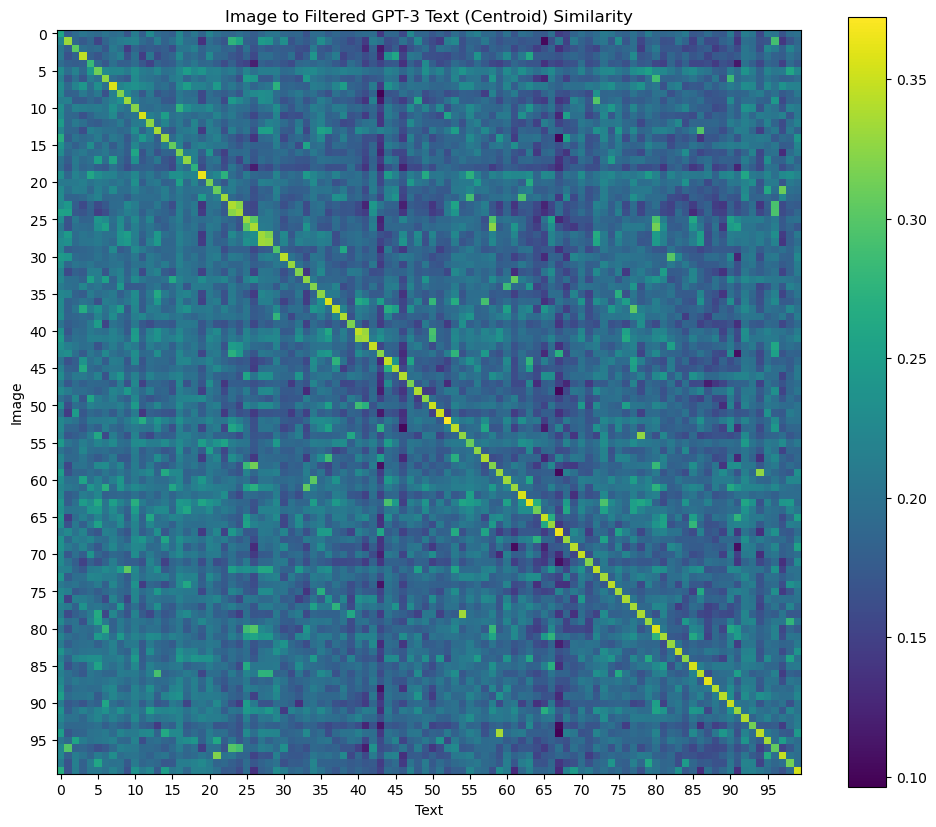

Rank 1: (28)crocodile_head - (27)crocodile, error rate: 0.8
Rank 2: (21)chair - (97)windsor_chair, error rate: 0.631578947368421
Rank 3: (54)ketch - (78)schooner, error rate: 0.47058823529411764
Rank 4: (96)wild_cat - (1)leopard, error rate: 0.4
Rank 5: (59)lotus - (94)water_lilly, error rate: 0.35
Rank 6: (58)lobster - (26)crayfish, error rate: 0.3076923076923077
Rank 7: (41)flamingo_head - (40)flamingo, error rate: 0.2857142857142857
Rank 8: (78)schooner - (54)ketch, error rate: 0.2777777777777778
Rank 9: (33)dragonfly - (61)mayfly, error rate: 0.25
Rank 10: (96)wild_cat - (23)cougar_body, error rate: 0.2
Rank 11: (26)crayfish - (58)lobster, error rate: 0.19047619047619047
Rank 12: (29)cup - (38)ewer, error rate: 0.1111111111111111
Rank 13: (43)gerenuk - (67)okapi, error rate: 0.1
Rank 14: (10)binocular - (51)inline_skate, error rate: 0.1
Rank 15: (10)binocular - (7)barrel, error rate: 0.1
Rank 16: (43)gerenuk - (23)cougar_body, error rate: 0.1
Rank 17: (22)chandelier - (62)menorah, 

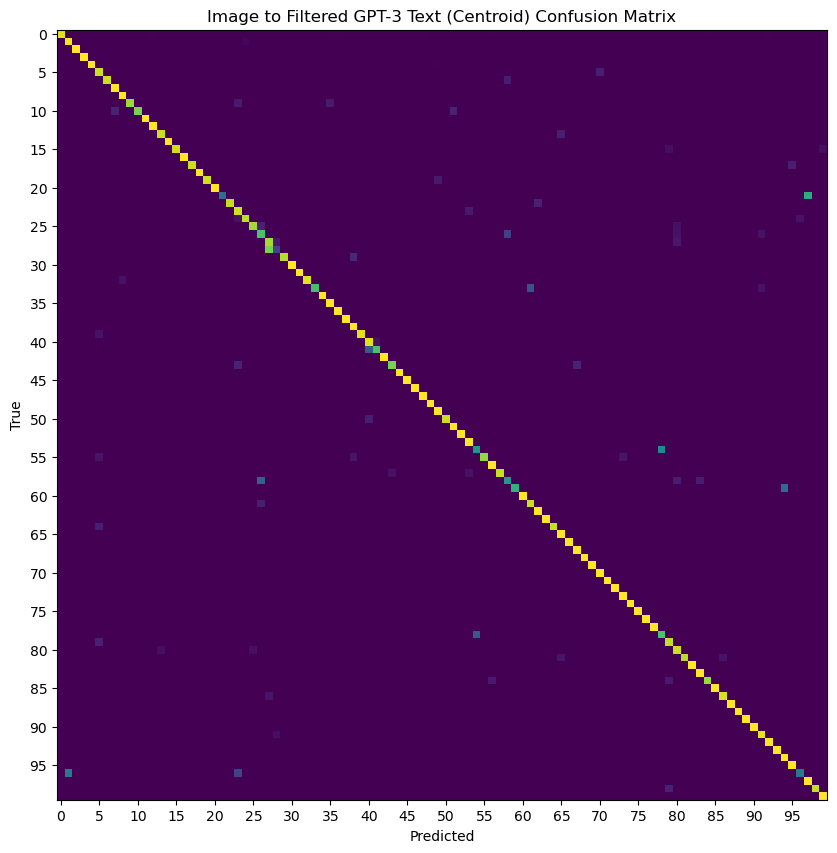

Image to filtered gpt-3 text (individual avg) similarity mean: 0.18413878977298737
Image to filtered gpt-3 text (individual avg) similarity std: 0.026632796972990036
Image to filtered gpt-3 text (individual avg) similarity diagonal mean: 0.3143872022628784
Image to filtered gpt-3 text (individual avg) similarity diagonal std: 0.01879248209297657
Image to filtered gpt-3 text (individual avg) similarity non-diagonal mean: 0.18282315135002136
Image to filtered gpt-3 text (individual avg) similarity non-diagonal std: 0.023233860731124878
Image to filtered gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.719624638557434
Rank 1: (78)schooner - (54)ketch, similarity: 0.323974609375
Rank 2: (28)crocodile_head - (27)crocodile, similarity: 0.3154296875
Rank 3: (41)flamingo_head - (40)flamingo, similarity: 0.314697265625
Rank 4: (40)flamingo - (41)flamingo_head, similarity: 0.31396484375
Rank 5: (54)ketch - (78)schooner, similarity: 0.313232421875
Rank 6: (94)wat

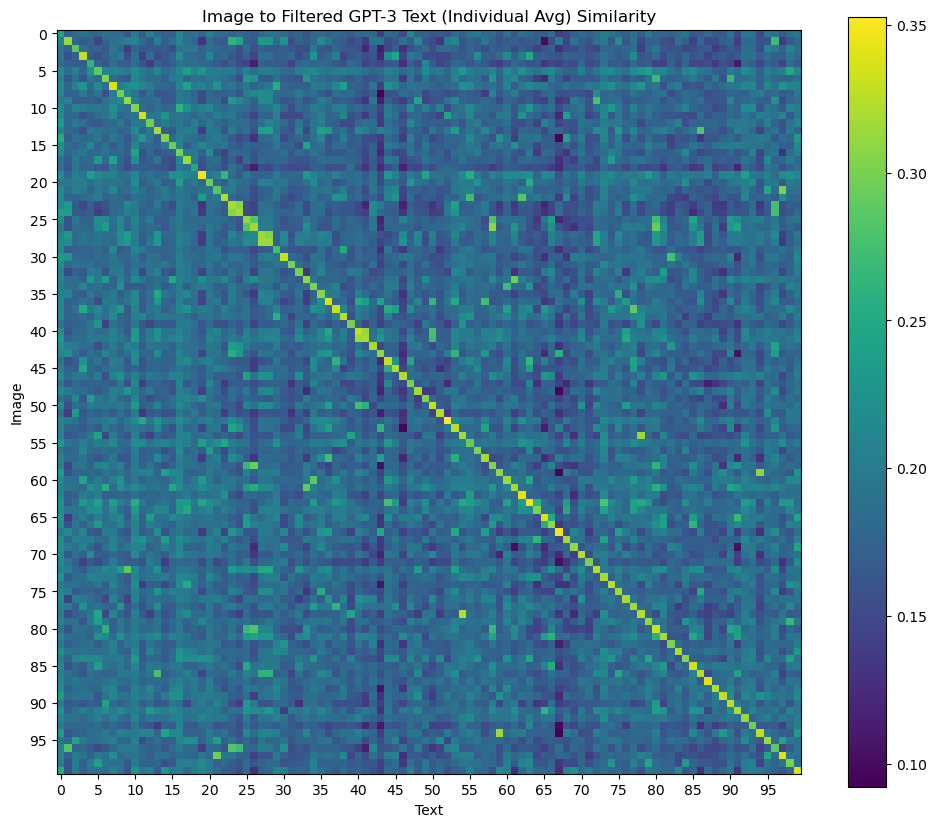

Rank 1: (21)chair - (97)windsor_chair, error rate: 0.7894736842105263
Rank 2: (96)wild_cat - (1)leopard, error rate: 0.5
Rank 3: (28)crocodile_head - (27)crocodile, error rate: 0.4666666666666667
Rank 4: (59)lotus - (94)water_lilly, error rate: 0.45
Rank 5: (78)schooner - (54)ketch, error rate: 0.3888888888888889
Rank 6: (58)lobster - (26)crayfish, error rate: 0.3076923076923077
Rank 7: (41)flamingo_head - (40)flamingo, error rate: 0.2857142857142857
Rank 8: (54)ketch - (78)schooner, error rate: 0.2647058823529412
Rank 9: (33)dragonfly - (61)mayfly, error rate: 0.25
Rank 10: (26)crayfish - (58)lobster, error rate: 0.23809523809523808
Rank 11: (96)wild_cat - (23)cougar_body, error rate: 0.2
Rank 12: (29)cup - (38)ewer, error rate: 0.16666666666666666
Rank 13: (43)gerenuk - (67)okapi, error rate: 0.1
Rank 14: (43)gerenuk - (23)cougar_body, error rate: 0.1
Rank 15: (10)binocular - (7)barrel, error rate: 0.1
Rank 16: (10)binocular - (51)inline_skate, error rate: 0.1
Rank 17: (22)chandelier

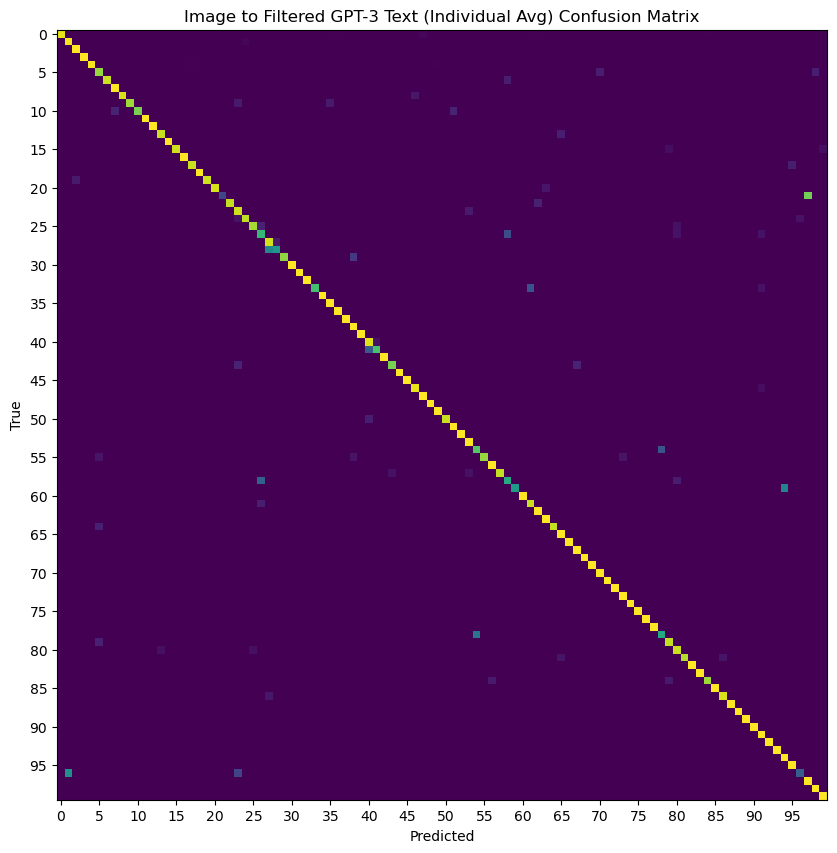

In [35]:
# Auto-similarity of image features
visualize_auto_similarity(img_masked_similarity, 'Image')

# Image to text similarity
visualize_cross_similarity(img_cls_name_similarity, cls_name_cm, 'Image to Class Name')
visualize_cross_similarity(img_template_cls_similarity, template_cls_cm, 'Image to Text Template (Centroid)')
visualize_cross_similarity(img_template_text_similarity, template_text_cm, 'Image to Text Template (Individual Avg)')
visualize_cross_similarity(img_original_gpt3_cls_similarity, original_gpt3_cls_cm, 'Image to Original GPT-3 Text (Centroid)')
visualize_cross_similarity(img_original_gpt3_text_similarity, original_gpt3_text_cm, 'Image to Original GPT-3 Text (Individual Avg)')
visualize_cross_similarity(img_filtered_gpt3_cls_similarity, filtered_gpt3_cls_cm, 'Image to Filtered GPT-3 Text (Centroid)')
visualize_cross_similarity(img_filtered_gpt3_text_similarity, filtered_gpt3_text_cm, 'Image to Filtered GPT-3 Text (Individual Avg)')

In [36]:
# Concatenate all features and labels to be used for plotting
all_label_ids = np.concatenate([cls_name_label_ids, template_label_ids, original_gpt3_label_ids, filtered_gpt3_label_ids])
all_features = np.concatenate([cls_name_features, template_text_features, original_gpt3_text_features, filtered_gpt3_text_features])

cls_name_start_idx = 0
cls_name_end_idx = len(cls_name_features)
template_start_idx = len(cls_name_features)
template_end_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_start_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_start_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features) + len(filtered_gpt3_text_features)

In [37]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, metric='cosine', perplexity=100)
transformed_features = tsne.fit_transform(all_features)

In [38]:
import matplotlib.pyplot as plt

def plot_features_2d(features, label_ids, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(features[:, 0], features[:, 1], c=label_ids, cmap='hsv')
    for label_id in range(len(cls_names_sorted)):
        plt.annotate(label_id, (features[label_ids == label_id, 0].mean(), features[label_ids == label_id, 1].mean()), ha='center', va='center', fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

Rank 1: (27)crocodile - (28)crocodile_head, similarity: 0.94677734375
Rank 2: (23)cougar_body - (24)cougar_face, similarity: 0.923828125
Rank 3: (40)flamingo - (41)flamingo_head, similarity: 0.90966796875
Rank 4: (25)crab - (26)crayfish, similarity: 0.8984375
Rank 5: (0)face - (12)brain, similarity: 0.89208984375
Rank 6: (21)chair - (95)wheelchair, similarity: 0.89013671875
Rank 7: (0)face - (24)cougar_face, similarity: 0.89013671875
Rank 8: (25)crab - (58)lobster, similarity: 0.8837890625
Rank 9: (15)butterfly - (33)dragonfly, similarity: 0.8818359375
Rank 10: (26)crayfish - (58)lobster, similarity: 0.8798828125


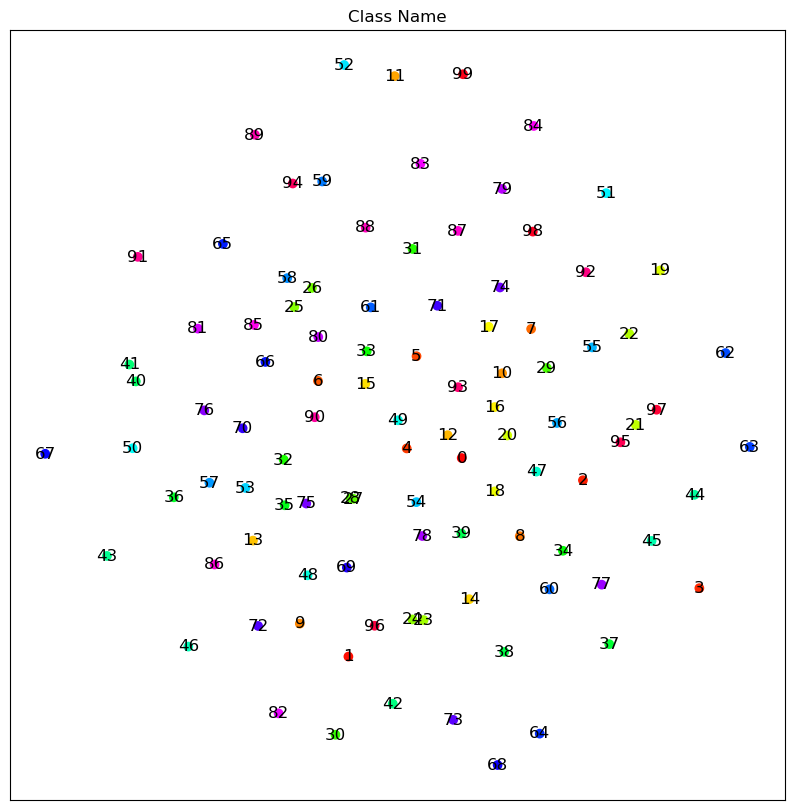

Rank 1: (27)crocodile - (28)crocodile_head, similarity: 0.955078125
Rank 2: (40)flamingo - (41)flamingo_head, similarity: 0.9287109375
Rank 3: (23)cougar_body - (24)cougar_face, similarity: 0.91748046875
Rank 4: (26)crayfish - (58)lobster, similarity: 0.89990234375
Rank 5: (25)crab - (26)crayfish, similarity: 0.89453125
Rank 6: (25)crab - (58)lobster, similarity: 0.89453125
Rank 7: (16)camera - (20)cellphone, similarity: 0.890625
Rank 8: (4)airplane - (49)helicopter, similarity: 0.890625
Rank 9: (21)chair - (95)wheelchair, similarity: 0.888671875
Rank 10: (0)face - (12)brain, similarity: 0.88818359375


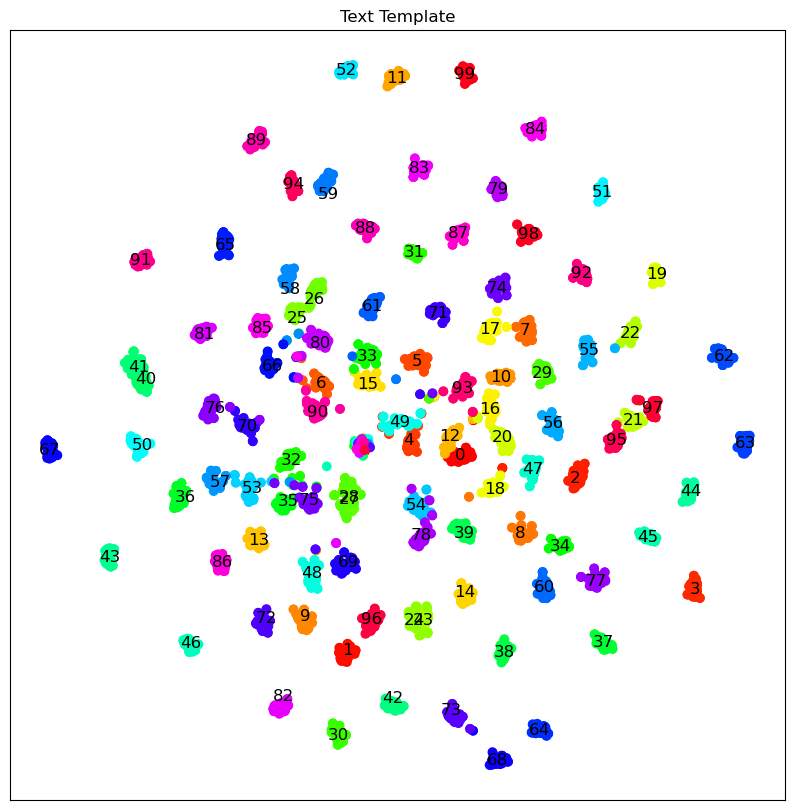

Rank 1: (27)crocodile - (28)crocodile_head, similarity: 0.9716796875
Rank 2: (23)cougar_body - (24)cougar_face, similarity: 0.96142578125
Rank 3: (40)flamingo - (41)flamingo_head, similarity: 0.9169921875
Rank 4: (54)ketch - (78)schooner, similarity: 0.9150390625
Rank 5: (26)crayfish - (58)lobster, similarity: 0.9111328125
Rank 6: (23)cougar_body - (96)wild_cat, similarity: 0.908203125
Rank 7: (25)crab - (58)lobster, similarity: 0.90576171875
Rank 8: (24)cougar_face - (96)wild_cat, similarity: 0.89990234375
Rank 9: (59)lotus - (94)water_lilly, similarity: 0.8984375
Rank 10: (35)elephant - (75)rhino, similarity: 0.89794921875


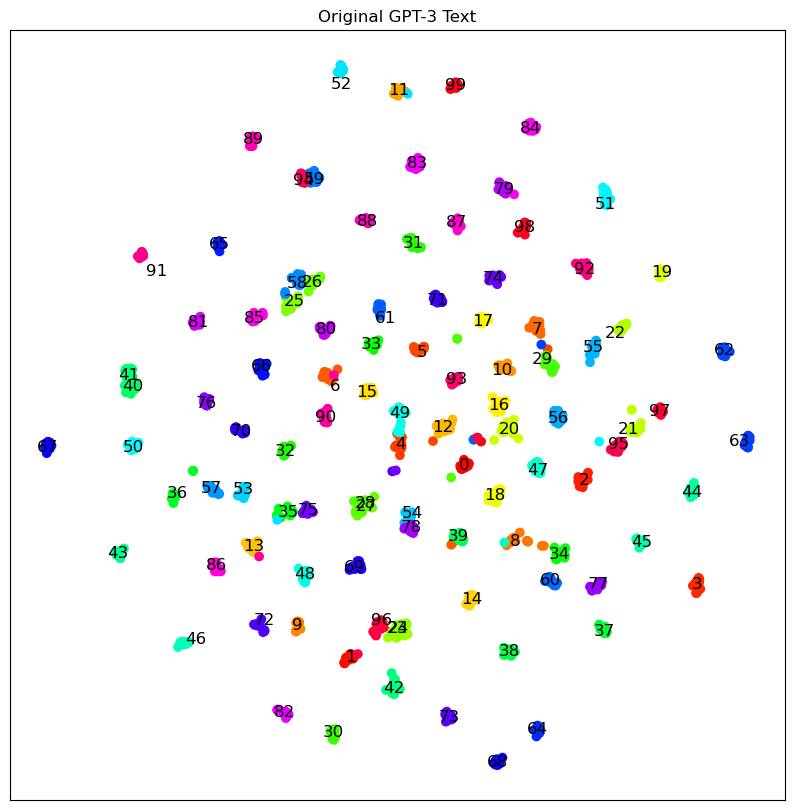

Rank 1: (27)crocodile - (28)crocodile_head, similarity: 0.9716796875
Rank 2: (23)cougar_body - (24)cougar_face, similarity: 0.9619140625
Rank 3: (40)flamingo - (41)flamingo_head, similarity: 0.91748046875
Rank 4: (54)ketch - (78)schooner, similarity: 0.91357421875
Rank 5: (26)crayfish - (58)lobster, similarity: 0.91357421875
Rank 6: (25)crab - (58)lobster, similarity: 0.90771484375
Rank 7: (23)cougar_body - (96)wild_cat, similarity: 0.90771484375
Rank 8: (35)elephant - (75)rhino, similarity: 0.90185546875
Rank 9: (24)cougar_face - (96)wild_cat, similarity: 0.89794921875
Rank 10: (59)lotus - (94)water_lilly, similarity: 0.89794921875


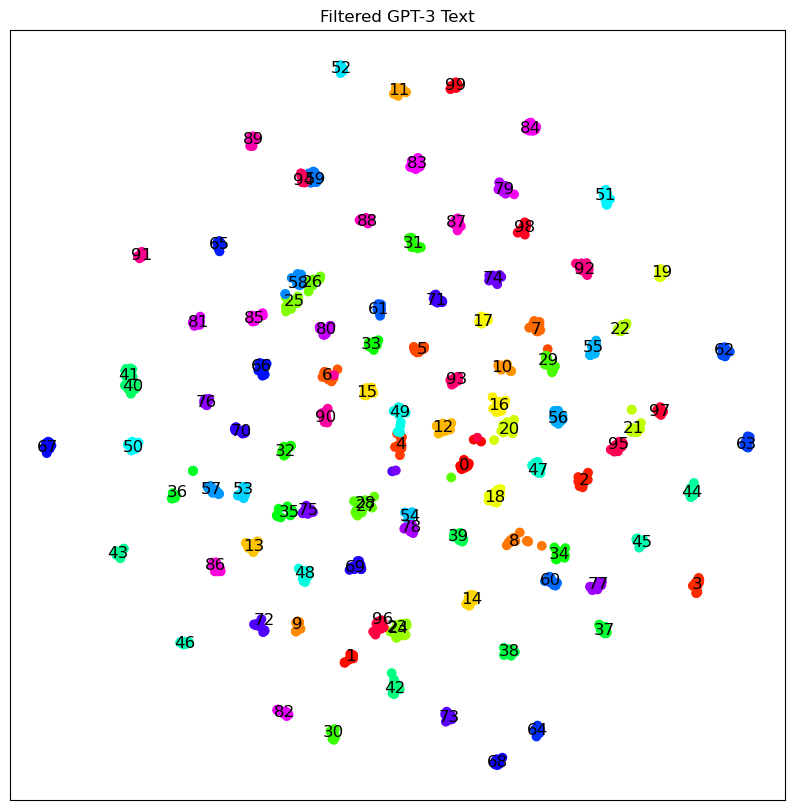

In [39]:
print_top_pairs(np.triu(cls_name_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[cls_name_start_idx:cls_name_end_idx], all_label_ids[cls_name_start_idx:cls_name_end_idx], 'Class Name')
print_top_pairs(np.triu(template_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[template_start_idx:template_end_idx], all_label_ids[template_start_idx:template_end_idx], 'Text Template')
print_top_pairs(np.triu(original_gpt3_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[original_gpt3_start_idx:original_gpt3_end_idx], all_label_ids[original_gpt3_start_idx:original_gpt3_end_idx], 'Original GPT-3 Text')
print_top_pairs(np.triu(filtered_gpt3_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[filtered_gpt3_start_idx:filtered_gpt3_end_idx], all_label_ids[filtered_gpt3_start_idx:filtered_gpt3_end_idx], 'Filtered GPT-3 Text')